##### 注意事項


© [2024]. [Shin-ichi Ito]. 本ノートブックに含まれるオリジナルコードおよび内容の著作権は著者に帰属します。本ノートブックのダウンロードおよび改変は自由ですが、改変したコードを利用する際には、元の著者のクレジットを明記してください。また、本ノートブックを改変した場合は、その内容に関する責任は全て改変者に移ります。
<br>

このノートブックは、伊藤のアジョイント法講義の補足資料として作成したものです。
以下のコード部分では、パラメータなど好きに変えて実行できます。
（基本的に）セル内の変数は他のセルから影響を受けないように設計されているので、
各セルを独立に実行できます。（なので若干冗長なコードになっています。）
実行・改変する際には、このノートブックを2窓で2つ開いて片方を参照用、もう片方を改変用にしておくのがオススメです。

<br>

本ノートブックでは、実際にアジョイント法を使うユーザが増えてくれることを期待して、概論にとどまらず、アジョイント法に関する著者が重要と思うことを、逐次充実させていきます。

#アジョイント法による勾配計算：解ける非線形方程式を例として

アジョイント法は、微分方程式に従う変数を引数に持つスカラー関数に対して、微分方程式の初期値に関する微分（勾配）を得る方法である。
<br>
特に多自由度の場合に効率的に勾配を得ることができ、変分データ同化、ニューラルネットワークなど、適用・応用範囲は広い。
<br>
本ノートブックでは、簡単なモデルへの適用を通じてアジョイント法の基礎的な実行・実装の方法を学ぶことを目的としている。

<br>

目標①：アジョイントモデルの厳密解による"勾配"とForwardモデル厳密解をコスト関数へ代入・微分して得た勾配の一致をみる。

目標②：離散化されたアジョイント方程式の数値計算による"勾配"を用いてパラメータの最適化を実施する。

目標③：推定するパラメータが2つ以上の場合の最適化を実践する。

<br>
<br>
<br>



## 1.0 ロジスティック方程式

アジョイント法を適用するモデルとして、[ロジスティック方程式](https://ja.wikipedia.org/wiki/%E3%83%AD%E3%82%B8%E3%82%B9%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%E6%96%B9%E7%A8%8B%E5%BC%8F)を採用する。



\begin{equation}
\frac{dx_{t}}{dt} = rx_{t}\left( 1-\frac{x_{t}}{K} \right)
\end{equation}
<br>
ここで、$r$ と $K$ は既知の定数であり、のちの利便性のために $x_{t}$ の初期値 $x_{0}$ に $\theta$ と名前をつけておく。



ロジスティック方程式は生物などの個体数変化を表す簡単な数理モデルとなっている。
$x_{t}$ 時刻 $t$ での個体数、$1/r$ が時定数、$K$ が飽和個体数を表す。




ロジスティック方程式は非線形常微分方程式であるが、幸運なことに解析的に解け、その解析解は
<br>
\begin{equation}
x_{t}=\frac{Ke^{rt}}{e^{rt}+K/\theta-1}
\end{equation}
<br>
となる。

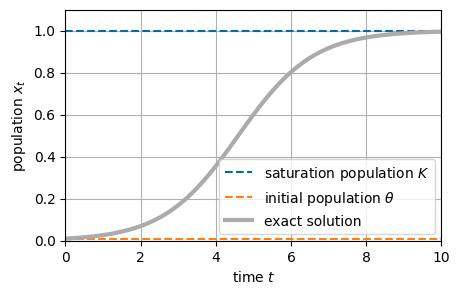

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.01

# 厳密解
def exact_solution(t):
  return K / ( 1 + (K/theta-1)*torch.exp(-r*t) )

# 描画
Tmax = 10.0
t = torch.linspace(0,Tmax,100)
figheight = 3
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))
ax.plot(t,torch.ones_like(t)*K, label=r"saturation population $K$",linestyle="--")
ax.plot(t,torch.ones_like(t)*theta, label=r"initial population $\theta$",linestyle="--")
ax.plot(t,exact_solution(t), label="exact solution", lw=3,linestyle="-")
ax.grid("--")
ax.legend()
ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"population $x_{t}$")
ax.set_xlim(0,Tmax)
ax.set_ylim(0,1.1*max([K,theta]))
plt.show()
plt.close()


【演習】
1.   パラメータ theta, r, K を変えて解の形を観察せよ。



<br>

## 1.1 問題設定



時刻 $t=T$ の時に個体数 $y$ が観測できたとして、
時刻 $t=0$ での個体数 $\theta$ を推定する問題を考える。
（今回は、モデルの不確定さ、観測する際の誤差などは考えず、とても理想的な状況を考える。）

コスト関数を定義する。

\begin{equation}
C = \frac{1}{2}(y-x_{T})^{2}
\end{equation}

コスト関数が初期値$\theta$の関数で、真の値で最小になっていることを確かめる。

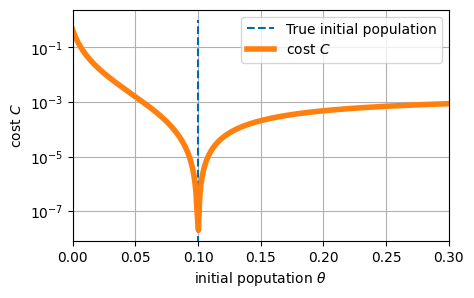

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻
T = 5.0
T = torch.tensor(T)


# 観測時刻での個体数 y
y = exact_solution(T,theta)

# 初期値を変化させて、コスト関数を計算
_theta = torch.linspace(0,K*0.3,300)
C = 0.5 * torch.square( y - exact_solution(T,_theta) )


# 描画
figheight = 3
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))
ax.plot(theta*torch.ones(2),[0,1], label="True initial population",linestyle="--")
ax.plot(_theta,C, label=r"cost $C$",lw=4)
ax.grid("--")
ax.legend()
ax.set_xlabel(r"initial poputation $\theta$")
ax.set_ylabel(r"cost $C$")
ax.set_yscale("log")
ax.set_xlim(torch.min(_theta),torch.max(_theta))
plt.show()
plt.close()


【考察】
1.   このコスト関数の極小値（最小値）がなぜ1つだけなのか考察せよ。

> 通常、アジョイント法を運用するような大規模系では極小値が大量にあり、最適化のハイパーパラメタチューニングの試行錯誤で大変苦労するというのはよくある話である。


<br>

## 1.2 ロジスティック方程式のアジョイント方程式

上記のコスト関数の最小値を探索することで、パラメータ $\theta$ を最適化することを考える。
この例題では、パラメータが1つなので上のような絵を描けばコスト関数の全体像が分かり最小値が一目でわかる(そのような最適化法をグリッドサーチという)が、実際の問題で直面するような多数のパラメータの最適化の場合には、もちろんコスト関数の全体像を描くことはほとんど不可能である。
<br>
<br>

こういった場合には、通常、勾配法による最適化を行う。
勾配法とは、コスト関数の微分（勾配）を計算し、コスト関数が小さくなる方向（勾配と反対方向）にパラメータをちょっとずつ更新していく方法である。
<br>
<br>

<img src="https://drive.google.com/uc?id=1Kxo7gsUsAKFsozdcn38StFLrCpfhSzVC" alt="実行ボタンの画像" title="勾配法のイメージ" width=50%>



勾配法という名前から明らかなように、勾配法による最適化では、コスト関数の勾配が必要である。

今回の問題設定では、$x_{t}$ の初期値 $\theta$ に関するコスト関数の勾配 $\dfrac{d C}{d \theta}$ が欲しい。
<br>
<br>

今回は解析解を知っているので、コスト関数に解析解の $x_{T}$ を直接代入し、コスト関数を $\theta$ で直接微分して勾配を得ることができる。<br>しかし通常の状況では解析解を知らないので、$x_{T}$ を $\theta$ の関数で陽に書けないためにコスト関数を陽に$\theta$ の関数として書くことができないので、直接微分ができないという状況が発生する。
<br>
<br>

アジョイント法は、微分方程式の解がコスト関数の引数となっている状況で、コスト関数を微分方程式の初期値で微分したい時に利用する方法である。<br>今回の例では、幸運なことにロジスティック方程式の解析解は知っているので、

* (I)  アジョイント法によって求められた"勾配"
* (II) 解析解をコスト関数に代入して直接 $\theta$ で微分して得た勾配

を比べることができる。（当然ながら、解析解を求められない問題では、後者を得ることはできない）

<br>
<br>

ロジスティック方程式のアジョイント方程式から、"勾配"を求めてみよう。
<br>
ロジスティック方程式のアジョイント方程式は以下のように与えられる。

\begin{equation}
-\frac{d\lambda_{t}}{dt} = r\left( 1- \frac{2x_{t}}{K}\right)\lambda_{t}
\end{equation}
ただし、$\lambda_{t}$は終点条件
\begin{equation}
\lambda_{T} = \frac{d C}{d x_{T}} = -\left(y - x_{T}\right)
\end{equation}
と、始点条件
\begin{equation}
\lambda_{0} = \frac{d C}{d x_{0}} = \frac{d C}{d \theta}
\end{equation}
を満たす。



この1章では利用しないが、同値な表現として、アジョイント方程式と終端条件は、以下のように、終端条件をデルタ関数の"撃力"として方程式に埋め込んだものとしても表すことができる。
<br>
\begin{equation}
\begin{aligned}
-\frac{d\lambda_{t}}{dt} & = r\left( 1- \frac{2x_{t}}{K}\right)\lambda_{t} + \delta(t-T) \frac{d C}{d x_{T}}\\
\lambda_{T'}&=0
\end{aligned}
\end{equation}
<br>
ただし、$\delta(x)$ はディラックのデルタ関数、$T'$ は $T$ よりも適当に大きい時刻を表す。


アジョイント方程式と終点・始点条件を見れば分かるように、アジョイント法は、コスト関数を $\theta$ の関数として陽に書くことができない時でも、代わりに、「何らかの方法でアジョイント方程式を解く」ことができれば、$\dfrac{d C}{d \theta}$ を $\lambda_{0}$ として求めることができる方法となっている。

今回のケースでは、このアジョイント方程式を終点条件の元で解くことで
$t=0$ での厳密解 $\lambda_{0}$ の値は以下のようになる。
\begin{equation}
\lambda_{0}= -\left(y - x_{T}\right) e^{rT} \left( \frac{K/\theta}{e^{rT} + K/\theta -1} \right)^{2}
\end{equation}


(I) の $\lambda_{0}$ として得られる"勾配"と、

(II) のロジスティック方程式の厳密解を直接コスト関数に代入したものを微分して得られる勾配（手でも計算できるが、上の式と同じ式が得られて自明なので、ここではあえてコスト関数を自動微分で $\theta$ 微分して計算する）を比較してみよう。

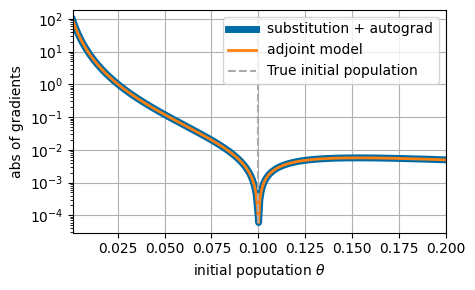

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)
import numpy as np

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 観測時刻での個体数 y
y = exact_solution(T,theta).item()

# 色々な初期値に対してx_{T}を計算、それらを代入してコスト関数を計算、自動微分でその勾配を計算
_theta = torch.linspace(0.001,K*0.2,300,requires_grad=True)
C = 0.5 * torch.square( y - exact_solution(T,_theta) )
Direct_grad = torch.autograd.grad(C,_theta,grad_outputs=torch.ones_like(C))[0]

# Adjointモデルの厳密解のt=0での値を計算。
def adjoint_exact(t,_theta,y):
  x = exact_solution(T,_theta)
  return -(y-x)*torch.exp(r*T) * torch.square( K/_theta / (torch.exp(r*T) + K/_theta - 1)  )
Adjoint_grad = adjoint_exact(T,_theta,y)

# torch -> numpy
Direct_grad = Direct_grad.detach().numpy()
Adjoint_grad = Adjoint_grad.detach().numpy()
_theta = _theta.detach().numpy()

# 描画
figheight = 3
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))

# 勾配の絶対値を対数表示
Direct_grad, Adjoint_grad = np.abs(Direct_grad), np.abs(Adjoint_grad)
ax.plot(_theta,Direct_grad, label="substitution + autograd",lw=5)
ax.plot(_theta,Adjoint_grad, label="adjoint model",lw=2)
ax.plot(theta*torch.ones(2),[Direct_grad.min(),Direct_grad.max()], label="True initial population",linestyle="--")
ax.grid("--")
ax.legend()
ax.set_xlabel(r"initial poputation $\theta$")
ax.set_ylabel("abs of gradients")
ax.set_yscale("log")
ax.set_xlim(_theta.min(),_theta.max())
plt.tight_layout()
plt.show()
plt.close()


確かに、アジョイント方程式の $t=0$ での厳密解 $\lambda_{0}$ として得られる”勾配”と、コスト関数を直接 $\theta$ 微分して得た勾配は厳密に一致していることが観察できる。

<br>

##1.3 勾配の厳密解を使った最適化のデモ



アジョイント方程式の厳密解で得られる勾配を使って、実際に最適化を実施する。

最適化法として[最急降下法](https://ja.wikipedia.org/wiki/%E6%9C%80%E6%80%A5%E9%99%8D%E4%B8%8B%E6%B3%95)を用いる。

最急降下法では、適当な初期推定値（Initial guess）$\theta_{0}$ からスタートして以下の漸化式を逐次更新することで最適化が実施される。

\begin{equation}
\theta_{k+1} = \theta_{k} - \eta \frac{d C}{d \theta_{k}}
\end{equation}
ここで、$k$ は反復回数の添え字、$\eta$ は学習率。


 epoch: 0   value: 5.00000e-02   cost: 1.58582e-03
 epoch: 100   value: 8.15755e-02   cost: 8.89302e-05
 epoch: 200   value: 8.93810e-02   cost: 2.49398e-05
 epoch: 300   value: 9.33054e-02   cost: 9.15022e-06
 epoch: 400   value: 9.56055e-02   cost: 3.76767e-06
 epoch: 500   value: 9.70506e-02   cost: 1.65024e-06
 epoch: 600   value: 9.79938e-02   cost: 7.49834e-07
 epoch: 700   value: 9.86237e-02   cost: 3.48671e-07
 epoch: 800   value: 9.90506e-02   cost: 1.64591e-07
 epoch: 900   value: 9.93426e-02   cost: 7.84795e-08
  true: 1.00000e-01   estimate: 9.95437e-02   relative error: 4.56344e-03

 elapsed time 1.1702175140 sec



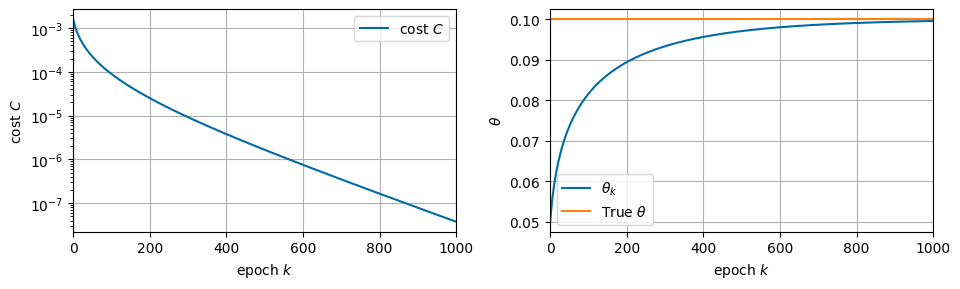

In [ ]:
import torch, time
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)
import numpy as np

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 観測時刻での個体数 y
y = exact_solution(T,theta).item()


# Adjointモデルの厳密解のt=0での値を計算。
def adjoint_exact(t,_theta,y):
  x = exact_solution(T,_theta)
  return -(y-x)*torch.exp(r*T) * torch.square( K/_theta / (torch.exp(r*T) + K/_theta - 1)  )


# 学習率
eta = 0.01

# 初期推定値
thetak = 0.05


# 最急降下法による最適化
thetak = torch.tensor(thetak)
history = []
start_time = time.time()
for epoch in range(1000):
  C = 0.5 * torch.square( y - exact_solution(T,thetak) )
  if epoch % 100 == 0: print(" epoch: {:d}   value: {:.5e}   cost: {:.5e}".format(epoch,thetak.item(),C.item()))
  history.append( [epoch,thetak.item(),C.item()] )
  grad = adjoint_exact(T,thetak,y)
  thetak = thetak - eta * grad
history = np.array(history).T

# 最終的に得られた推定値と真のthetaとの比較
print("  true: {:.5e}   estimate: {:.5e}   relative error: {:.5e}".format( theta, thetak.item(), np.abs(theta-thetak.item())/np.abs(theta)))
print("")
print(" elapsed time {:.10f} sec".format(time.time()-start_time))
print("")


# 描画
figheight = 3
fig, ax = plt.subplots(1,2, figsize=(figheight*2*1.618, figheight))
ax[0].plot(history[0],history[2], label=r"cost $C$",linestyle="-")
ax[0].grid("--")
ax[0].legend()
ax[0].set_xlabel(r"epoch $k$")
ax[0].set_ylabel(r"cost $C$")
ax[0].set_yscale("log")
ax[0].set_xlim(-1,history[0][-1]+1)
ax[1].plot(history[0],history[1], label=r"$\theta_{k}$",linestyle="-")
ax[1].plot([0,history[0][-1]], [theta,theta], label=r"True $\theta$",linestyle="-")
ax[1].grid("--")
ax[1].legend()
ax[1].set_xlabel(r"epoch $k$")
ax[1].set_ylabel(r"$\theta$")
ax[1].set_xlim(-1,history[0][-1]+1)
plt.tight_layout()
plt.show()
plt.close()


【演習】

1.   学習率を変えてみて、解がどのように収束するか観察せよ。
2.   初期推定値を変えてみて、解がどのように収束するか観察せよ。

【発展】
3.   一般には、最急降下法は最適値付近で収束が遅くなることが知られている。[Nesterovの加速勾配降下法](https://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf)や[Adam法](https://ja.wikipedia.org/wiki/%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95#Adam)など高速な最適化法を実践し、最急降下法の結果と比較してみよ。

###### 【発展】用のコード

 epoch: 0   value: 5.00000e-02   cost: 1.58582e-03
 epoch: 100   value: 8.15755e-02   cost: 8.89302e-05
 epoch: 200   value: 8.93810e-02   cost: 2.49398e-05
 epoch: 300   value: 9.33054e-02   cost: 9.15022e-06
 epoch: 400   value: 9.56055e-02   cost: 3.76767e-06
 epoch: 500   value: 9.70506e-02   cost: 1.65024e-06
 epoch: 600   value: 9.79938e-02   cost: 7.49834e-07
 epoch: 700   value: 9.86237e-02   cost: 3.48671e-07
 epoch: 800   value: 9.90506e-02   cost: 1.64591e-07
 epoch: 900   value: 9.93426e-02   cost: 7.84795e-08
  true: 1.00000e-01   estimate: 9.95437e-02   relative error: 4.56344e-03

 elapsed time 1.1526067257 sec



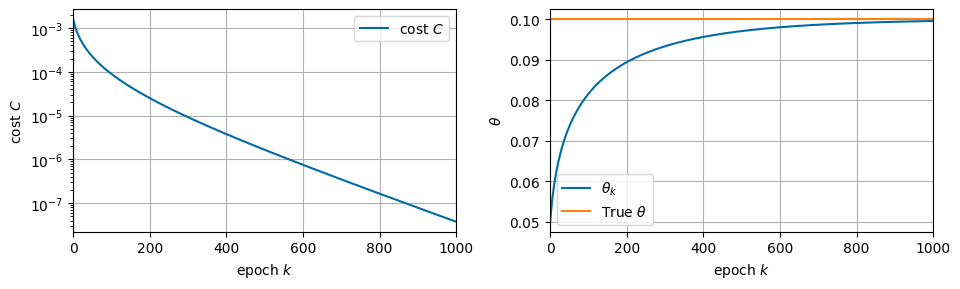

In [ ]:
import torch, time
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)
import numpy as np

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 観測時刻での個体数 y
y = exact_solution(T,theta).item()


# Adjointモデルの厳密解のt=0での値を計算。
def adjoint_exact(t,_theta,y):
  x = exact_solution(T,_theta)
  return -(y-x)*torch.exp(r*T) * torch.square( K/_theta / (torch.exp(r*T) + K/_theta - 1)  )


# 学習率
eta = 0.01

# 初期推定値
thetak = 0.05



# 最適化法による最適化
thetak = torch.tensor(thetak)


# =======================
# 最急降下法
#optimizer = torch.optim.SGD([thetak],lr=eta)
# Nesterovの加速勾配降下法
optimizer = torch.optim.SGD([thetak],lr=eta,nesterov=True,momentum=0.9)
# Adam法
#optimizer = torch.optim.Adam([thetak],lr=eta)
# ========================


history = []
start_time = time.time()
for epoch in range(1000):
  C = 0.5 * torch.square( y - exact_solution(T,thetak) )
  if epoch % 100 == 0: print(" epoch: {:d}   value: {:.5e}   cost: {:.5e}".format(epoch,thetak.item(),C.item()))
  history.append( [epoch,thetak.item(),C.item()] )

  grad = adjoint_exact(T,thetak,y)
  optimizer.zero_grad()
  thetak.grad = grad.data
  optimizer.step()


history = np.array(history).T

# 最終的に得られた推定値と真のthetaとの比較
print("  true: {:.5e}   estimate: {:.5e}   relative error: {:.5e}".format( theta, thetak.item(), np.abs(theta-thetak.item())/np.abs(theta)))
print("")
print(" elapsed time {:.10f} sec".format(time.time()-start_time))
print("")


# 描画
figheight = 3
fig, ax = plt.subplots(1,2, figsize=(figheight*2*1.618, figheight))
ax[0].plot(history[0],history[2], label=r"cost $C$",linestyle="-")
ax[0].grid("--")
ax[0].legend()
ax[0].set_xlabel(r"epoch $k$")
ax[0].set_ylabel(r"cost $C$")
ax[0].set_yscale("log")
ax[0].set_xlim(-1,history[0][-1]+1)
ax[1].plot(history[0],history[1], label=r"$\theta_{k}$",linestyle="-")
ax[1].plot([0,history[0][-1]], [theta,theta], label=r"True $\theta$",linestyle="-")
ax[1].grid("--")
ax[1].legend()
ax[1].set_xlabel(r"epoch $k$")
ax[1].set_ylabel(r"$\theta$")
ax[1].set_xlim(-1,history[0][-1]+1)
plt.tight_layout()
plt.show()
plt.close()

<br>
<br>
<br>

##1.4 ロジスティック方程式の数値計算


ロジスティック方程式およびそのアジョイント方程式は幸運なことに解析的に解けるが、

実際に私たちの解きたい微分方程式の問題の多くは解析的に解くことはできないため、方程式を数値計算によって解く必要がある。

<br>

ロジスティック方程式を数値計算で解いてみよう。

ここでの「時間微分を含む常微分方程式を数値計算で解く」とは、
時間を $t_{n}=nh\;(n=0,1,2...)$ と時間刻み幅 $h$ で離散化し、
それぞれの時刻での $x_{t_{n}}=x_{n}$ を

\begin{equation}
x_{0} \rightarrow x_{1} \rightarrow x_{2} \rightarrow \cdots \rightarrow x_{n-1} \rightarrow x_{n} \rightarrow \cdots
\end{equation}

と逐次的に計算していくこと、とする。つまり、何らかの方法で $x_{n+1}=F(x_{n})$ のような漸化式を作成し、$x_{0}$ から $x_{1}, x_{2}\cdots$, と順に生成する作業になる。

<br>

与えられた微分方程式から漸化式を作る方法は無数に存在するが、ここでは簡単に[陽的オイラー法](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%A4%E3%83%A9%E3%83%BC%E6%B3%95)による離散化を行う。

陽的オイラー法では、時間微分を

\begin{equation}
\left.\frac{dx_{t}}{dt}\right|_{t=t_{n}} = \lim_{h\rightarrow 0}\frac{x_{n+1} - x_{n}}{h} \approx \frac{x_{n+1} - x_{n}}{h}
\end{equation}

のような一階差分で近似し、方程式の右辺を $t=t_{n}$ で評価する。そうすると、離散化されたロジスティック方程式は以下のような漸化式になる。

\begin{equation}
x_{n+1} = x_{n}+ h r x_{n}\left( 1- \frac{x_{n}}{K}\right)
\end{equation}

この漸化式で得られる数値解と厳密解を比較してみよう。

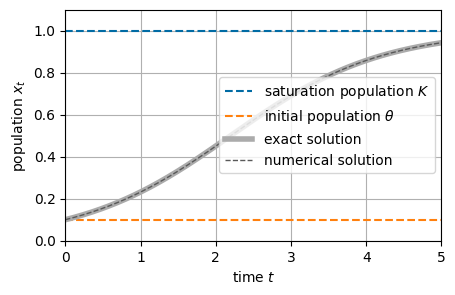

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numpy as np
torch.set_default_dtype(torch.float64)

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻での個体数 y
y = exact_solution(T,theta)

# ステップ数とシミュレーション時間長
num = 1000
Tmax = T
h = Tmax/num # タイムステップ

# シミュレーション（オイラー法による解）
t = torch.linspace(0,Tmax,num+1)
x = torch.tensor(theta)
history = [x.item()]
for _ in t[1:]:
  x = x + h * r * x * (1-x/K)
  history.append(x.item())


# 描画
figheight = 3
t_dense = torch.linspace(0,Tmax,1000)
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))
ax.plot(t_dense,torch.ones_like(t_dense)*K, label=r"saturation population $K$",linestyle="--")
ax.plot(t_dense,torch.ones_like(t_dense)*theta, label=r"initial population $\theta$",linestyle="--")
ax.plot(t_dense,exact_solution(t_dense,theta), label="exact solution", lw=4,linestyle="-")
ax.plot(t,history, label="numerical solution", lw=1,linestyle="--")
ax.grid("--")
ax.legend()
ax.set_xlabel(r"time $t$")
ax.set_ylabel(r"population $x_{t}$")
ax.set_xlim(0,Tmax)
ax.set_ylim(0,K*1.1)
plt.show()
plt.close()


<br>

【演習】

1.   パラメータ h, theta, r, K を変えて、数値計算結果を観察せよ。

【発展】
2.   陽的オイラー法の精度は $h$ の1次精度（テーラー展開で $h$ の1次まで厳密解と一致）であり、あまり精度が良い方法とは言えない。より高精度な解を得るためにはどうすれば良いか調査せよ。（キーワード：[ルンゲ=クッタ法](https://ja.wikipedia.org/wiki/%E3%83%AB%E3%83%B3%E3%82%B2%EF%BC%9D%E3%82%AF%E3%83%83%E3%82%BF%E6%B3%95)、[線形多段法](https://ja.wikipedia.org/wiki/%E7%B7%9A%E5%9E%8B%E5%A4%9A%E6%AE%B5%E6%B3%95)、[離散可積分系](https://kmaeda.net/kmaeda/demo/logistic/)など）

<br>
<br>
<br>

##1.5 ロジスティック方程式のアジョイント方程式の数値計算


ロジスティック方程式を陽的オイラー法で離散化して解いたのと同様に、アジョイント方程式も離散化して数値計算で解いてみよう。

再喝であるが、アジョイント方程式とその終点条件は以下のように与えられる。


\begin{equation}
-\frac{d\lambda_{t}}{dt} = r\left( 1- \frac{2x_{t}}{K}\right)\lambda_{t}
\end{equation}

\begin{equation}
\lambda_{T} = \frac{dC}{d x_{T}} = -\left(y - x_{T}\right)
\end{equation}

<br>

$t=t_{n}$ での $\lambda_{t}$ の値を $\lambda_{n}$ と書くことにする。

アジョイント方程式では、終点時刻 $t=T$ での $\lambda$ の値が与えられ、初期時刻 $t=0$ での $\lambda$ の値が欲しいという状況のため、
ロジスティック方程式の解き方と異なり、時間逆方向に時間発展させなければならない。そのため、$\lambda_{n+1}$ から $\lambda_{n}$ を生成する漸化式を構築する必要がある。

<br>

上記の要請を満たすために、アジョイント方程式の離散化はどのようなものが良いだろうか？ ロジスティック方程式の離散化で用いた陽的オイラー法と同じくアジョイント方程式の数値解も1次精度を達成する数値解を構成する離散化法として、例えば以下のようなものが考えられる。

<br>

1.   陰的オイラー法（時間微分を一階差分、右辺を $t=t_{n+1}$ で評価）で離散化

\begin{equation}
-\frac{\lambda_{n+1}-\lambda_{n}}{h} = r\left( 1- \frac{2x_{n+1}}{K}\right)\lambda_{n+1}\quad ⇒ \quad  \lambda_{n}=\left\{1 + hr\left( 1- \frac{2x_{n+1}}{K}\right)\right\}\lambda_{n+1}
\end{equation}

2.   陽的オイラー法（時間微分を一階差分、右辺を $t=t_{n}$ で評価）で離散化

\begin{equation}
-\frac{\lambda_{n+1}-\lambda_{n}}{h} = r\left( 1- \frac{2x_{n}}{K}\right)\lambda_{n}\quad ⇒ \quad \lambda_{n} = \left\{1-hr\left( 1- \frac{2x_{n}}{K}\right)\right\}^{-1} \lambda_{n+1}
\end{equation}

3.   少し"不思議"な方法①（時間微分を一階差分、右辺の $x_{t}$ を $t=t_{n}$、$\lambda_{t}$ を $t=t_{n+1}$ で評価）で離散化

\begin{equation}
-\frac{\lambda_{n+1}-\lambda_{n}}{h} = r\left( 1- \frac{2x_{n}}{K}\right)\lambda_{n+1}\quad ⇒ \quad \lambda_{n}=\left\{1 + hr\left( 1- \frac{2x_{n}}{K}\right)\right\}\lambda_{n+1}
\end{equation}

4.   少し"不思議"な方法②（時間微分を一階差分、右辺の $x_{t}$ を $t=t_{n+1}$、$\lambda_{t}$ を $t=t_{n}$ で評価）で離散化

\begin{equation}
-\frac{\lambda_{n+1}-\lambda_{n}}{h} = r\left( 1- \frac{2x_{n+1}}{K}\right)\lambda_{n}\quad ⇒ \quad \lambda_{n} = \left\{1-hr\left( 1- \frac{2x_{n+1}}{K}\right)\right\}^{-1} \lambda_{n+1}
\end{equation}

<br>

いずれの方法で得られる数値解も1次精度(厳密解との誤差は $O(h^2)$ )であり、 $h\rightarrow 0$ で元々のアジョイント方程式を復元するので、どれを使っても良さそうに見える。
実際、$h$が小さければ、どのアジョイント方程式の離散化法も、勾配をよく近似できていることが確認できる。

<br>

> 実際にアジョイント法を運用する場面において、どのような離散化法を選ぶかは、求められる精度・実装コスト・計算時間・計算メモリなど、様々な機械的もしくは人間的な拘束条件（要はユーザーの都合）を鑑みて決定されることが多い。（この例では実装コスト・計算時間・計算メモリに大差はない。）どの離散化法を用いても多かれ少なかれ誤差が発生するが、得られる"勾配"に多少誤差が乗ってしまっても、確率的勾配降下法やランジュバン-ダイナミクスのセンスで考えれば確率的には最適解に収束できると期待されるからである。

> 2.と4.については、この例においては $\lambda_{n}$ について陽に解けるので問題にならないが、一般に $x$ や $\lambda$ がベクトルの場合には、逆数の部分は逆行列の演算になるため、非常に計算が重く、ほとんどの場合実用に耐えない。が、写像 $\lambda_{n+1}\rightarrow \lambda_{n}$ が陰的解法になるため、["硬い"系](https://ja.wikipedia.org/wiki/%E7%A1%AC%E3%81%84%E6%96%B9%E7%A8%8B%E5%BC%8F)については採用の検討もあり得るかもしれない。

<br>

以下のコードではこれらの離散化で計算された"勾配"と、ロジスティック方程式の数値解をコスト関数に代入して微分したものと比較する。



In [ ]:
import torch, sys
import numpy as np
torch.set_default_dtype(torch.float64)

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻での個体数 y
y = exact_solution(T,theta)

# ステップ数とシミュレーション時間長
num = 1000
Tmax = T
h = Tmax/num # タイムステップ
t = torch.linspace(0,Tmax,num+1)


# ロジスティック方程式を陽的オイラー法で解く関数
def get_forward_solution(_theta):
  x = _theta
  history = [x.item()]
  for _ in t[1:]:
    x = x + h * r * x * (1-x/K)
    history.append(x.item())
  return history, x



# アジョイント方程式を解く関数
def get_adjoint_solution(x_history,method=1):
  lam = torch.tensor(-(y-x_history[-1]).item())

  if method == 1:
    x_reversed_history = list(reversed(x_history)) [:-1]
    for x in x_reversed_history:
      lam *= (1.0 + h * r * (1.0 - 2.0*x/K) )

  elif method == 2:
    x_reversed_history = list(reversed(x_history)) [1:]
    for x in x_reversed_history:
      lam /= (1.0 - h * r * (1.0 - 2.0*x/K) )

  elif method == 3:
    x_reversed_history = list(reversed(x_history)) [1:]
    for x in x_reversed_history:
      lam *= (1.0+ h * r * (1.0 - 2.0*x/K) )

  elif method == 4:
    x_reversed_history = list(reversed(x_history)) [:-1]
    for x in x_reversed_history:
      lam /= (1.0 - h * r * (1.0 - 2.0*x/K) )

  else:
    print(" method must be an integer between 1 and 4.")
    sys.exit()

  return lam.item()



# 真の theta からずれたところでの勾配を計算
_theta = theta + 0.1

method = 1

_theta = torch.tensor(_theta,requires_grad=True)
x_history, final_x = get_forward_solution(_theta)
lam = get_adjoint_solution(x_history,method=method)

print(" Numerical adjoint solution : {:.17e} ".format(lam))


#コスト関数にxの数値解を代入して微分したもの（自動微分で計算）
C = 0.5*torch.square( y - final_x )
grad = torch.autograd.grad(C,_theta,grad_outputs=torch.ones_like(C))[0].item()

print(" Autograd of cost function : {:.17e} ".format(grad))


 Numerical adjoint solution : 4.91830462735232208e-03 
 Autograd of cost function : 4.95654726966950586e-03 


<br>



【演習・考察】

1.   method を変えて、得られる勾配の値を比較してみよ。

2.   勾配を評価する場所(コードでは_theta)を変えて、いろいろな場所での勾配値を計算してみよ。特に_thetaが真のthetaと一致する時に勾配値が十分に小さくなっていることを確かめよ。

3.   _thetaが真のthetaと一致する時の勾配値はゼロに近いが、厳密にゼロにならないのはなぜか？

4.   時間刻み $h$ を変えて、勾配を計算して比較してみよ。

<br>

> 方法1~4のどの方法も勾配の値を($h$ が小さければ)よく近似できているが、1つだけ、自動微分で得られる勾配と異常なほどに一致しているものがある。実はこの離散化法で得られる"勾配"は自動微分で得られる勾配と丸め誤差の影響を除くと厳密に一致することが証明されている。<br>この離散化法は、陽的オイラー法で離散化されたロジスティック方程式の漸化式を拘束条件にしたラグランジュ関数の変分計算から得られるが、より数学的にはフォワード方程式とそれに対応するアジョイント方程式のペアが成す系に時間に依存しない保存量が存在していることに起因する。本ノートブックでは導出等の説明はしないが、数学的な詳細を知りたい方は [Sanz-Serna (2016)](https://epubs.siam.org/doi/10.1137/151002769) [arXiv版](https://arxiv.org/abs/1503.04021)などを参照すると良い。

<br>
<br>
<br>

##1.6 アジョイント方程式の数値解を使った最適化のデモ

アジョイント方程式の数値解で得られた"勾配"を使って、最適化のデモを行う。

上記【1.3 厳密勾配を使った最適化のデモ】の勾配計算の部分を数値解による"勾配"計算に置き換えただけ。

 epoch: 0   value: 5.00000e-02   exact cost: 1.58582e-03 numerical cost: 1.59650e-03
 epoch: 100   value: 8.15356e-02   exact cost: 8.93962e-05 numerical cost: 8.91048e-05
 epoch: 200   value: 8.93179e-02   exact cost: 2.52706e-05 numerical cost: 2.49485e-05
 epoch: 300   value: 9.32278e-02   exact cost: 9.37816e-06 numerical cost: 9.14084e-06
 epoch: 400   value: 9.55180e-02   exact cost: 3.92587e-06 numerical cost: 3.75885e-06
 epoch: 500   value: 9.69560e-02   exact cost: 1.76095e-06 numerical cost: 1.64422e-06
 epoch: 600   value: 9.78941e-02   exact cost: 8.27822e-07 numerical cost: 7.46107e-07
 epoch: 700   value: 9.85201e-02   exact cost: 4.03934e-07 numerical cost: 3.46471e-07
 epoch: 800   value: 9.89441e-02   exact cost: 2.03995e-07 numerical cost: 1.63329e-07
 epoch: 900   value: 9.92340e-02   exact cost: 1.06785e-07 numerical cost: 7.77699e-08
  true: 1.00000e-01   estimate: 9.94334e-02   relative error: 5.66630e-03

 elapsed time 89.2612693310 sec



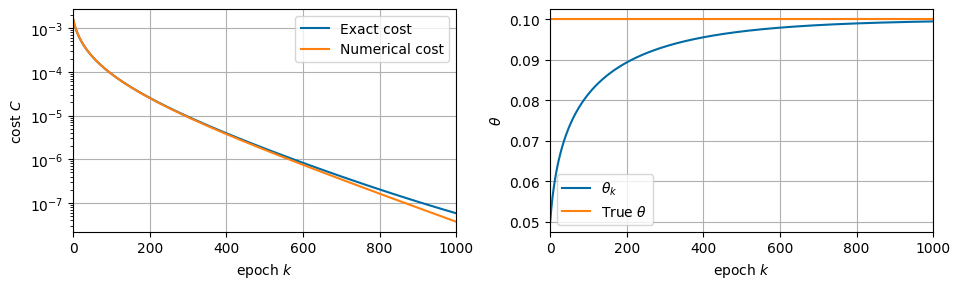

In [ ]:
import torch,time
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)
import numpy as np

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 厳密解
def exact_solution(t,_theta):
  return K / ( 1 + (K/_theta-1)*torch.exp(-r*t) )

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 観測時刻での個体数 y
y = exact_solution(T,theta).item()



# ステップ数とシミュレーション時間長
num = 1000
Tmax = T
h = Tmax/num # タイムステップ
t = torch.linspace(0,Tmax,num+1)



# ロジスティック方程式を陽的オイラー法で解く関数
def get_forward_solution(_theta):
  x = _theta
  history = [x.item()]
  for _ in t[1:]:
    x = x + h * r * x * (1-x/K)
    history.append(x.item())
  return history, x


# アジョイント方程式を解く関数
def get_adjoint_solution(x_history,method=1):
  lam = torch.tensor(-(y-x_history[-1]))

  if method == 1:
    x_reversed_history = list(reversed(x_history)) [:-1]
    for x in x_reversed_history:
      lam *= (1.0 + h * r * (1.0 - 2.0*x/K) )

  elif method == 2:
    x_reversed_history = list(reversed(x_history)) [1:]
    for x in x_reversed_history:
      lam /= (1.0 - h * r * (1.0 - 2.0*x/K) )

  elif method == 3:
    x_reversed_history = list(reversed(x_history)) [1:]
    for x in x_reversed_history:
      lam *= (1.0+ h * r * (1.0 - 2.0*x/K) )

  elif method == 4:
    x_reversed_history = list(reversed(x_history)) [:-1]
    for x in x_reversed_history:
      lam /= (1.0 - h * r * (1.0 - 2.0*x/K) )

  else:
    print(" method must be an integer between 1 and 4.")
    sys.exit()

  return lam

# コスト関数の定義
def exact_cost_function(_theta):
  C = 0.5 * torch.square( y - exact_solution(T,_theta) )
  return C.item()
def numerical_cost_function(_theta):
  theta = torch.tensor(_theta.item())
  x_history, final_x = get_forward_solution(theta)
  C = 0.5 * torch.square(torch.tensor(y-x_history[-1]))
  return C.item()



# 学習率
eta = 0.01

# 初期推定値
thetak = 0.05

# アジョイントモデルの離散化法
method = 1


# 最急降下法による最適化
thetak = torch.tensor(thetak)
history = []
start_time = time.time()
for epoch in range(1000):

  C_exact = exact_cost_function(thetak)
  C_numer = numerical_cost_function(thetak)
  if epoch % 100 == 0: print(" epoch: {:d}   value: {:.5e}   exact cost: {:.5e} numerical cost: {:.5e}".format(epoch,thetak.item(),C_exact,C_numer))
  history.append( [epoch,thetak.item(),C_exact,C_numer] )

  x_history, final_x = get_forward_solution(thetak)
  grad = get_adjoint_solution(x_history,method=method)
  thetak = thetak - eta * grad

history = np.array(history).T

# 最終的に得られた推定値と真のthetaとの比較
print("  true: {:.5e}   estimate: {:.5e}   relative error: {:.5e}".format( theta, thetak.item(), np.abs(theta-thetak.item())/np.abs(theta)))
print("")
print(" elapsed time {:.10f} sec".format(time.time()-start_time))
print("")


# 描画
figheight = 3
fig, ax = plt.subplots(1,2, figsize=(figheight*2*1.618, figheight))
ax[0].plot(history[0],history[2], label="Exact cost",linestyle="-")
ax[0].plot(history[0],history[3], label="Numerical cost",linestyle="-")
ax[0].grid("--")
ax[0].legend()
ax[0].set_xlabel(r"epoch $k$")
ax[0].set_ylabel(r"cost $C$")
ax[0].set_yscale("log")
ax[0].set_xlim(-1,history[0][-1]+1)
ax[1].plot(history[0],history[1], label=r"$\theta_{k}$",linestyle="-")
ax[1].plot([0,history[0][-1]], [theta,theta], label=r"True $\theta$",linestyle="-")
ax[1].grid("--")
ax[1].legend()
ax[1].set_xlabel(r"epoch $k$")
ax[1].set_ylabel(r"$\theta$")
ax[1].set_xlim(-1,history[0][-1]+1)
plt.tight_layout()
plt.show()
plt.close()


<br>

最適化1ステップの間にロジスティック方程式とそのアジョイント方程式の数値計算が１回ずつ必要なため、勾配厳密解をダイレクトに計算している【1.3 勾配の厳密解を使った最適化のデモ】での最適化計算よりも（デモの都合上少し余計な数値計算をしているが、それをさっ引いても）長い実行時間を要することが実感できる。通常、勾配厳密解を得ることは不可能であるため、アジョイント方程式の数値解を使った最適化では、内部の数値計算をいかに「早く」かつ「正確に」解けるように設計するかが重要となる。
（だが、残念ながら、「早く」と「正確に」は一般に両立しない。）
<br>


【演習】
1.   パラメータを変えて、収束の様子を観察せよ。



<br>
<br>

---

##2.0 推定したいパラメータが2つ以上の場合のデモ

上記までのデモでは、推定するパラメータが1つだけの場合だったが、実際にアジョイント法を用いるのは、多数のパラメータを推定したいという時がほとんどである。

そこで、同じくロジスティック方程式で、初期値$\theta$と時定数$r$、2つのパラメータを推定する問題を考えてみよう。時定数$r$は時間変化しないパラメータとする。
<br>
<br>

これまでの例で見たように、アジョイント法ができるのは、「コスト関数を微分方程式の初期値で微分する」ことなので、当然ながら各変数の微分方程式（時間発展方程式）が必要である。
<br>
$x$ に対応する時間発展方程式はロジスティック方程式だが、時定数 $r$ に対応する時間発展方程式はない。そのため、「時定数 $r$ は時間発展しない変数である」ことを表す時間発展方程式を新たに追加する。

\begin{equation}
\begin{aligned}
\frac{dx_{t}}{dt} &= r_{t}x_{t}\left( 1-\frac{x_{t}}{K} \right) \\
\frac{dr_{t}}{dt} &= 0
\end{aligned}
\end{equation}


ここで、$r$ に時刻の添字を新たに付けた。（実態は時間発展しない変数であることに注意。）

$r_{t}$ の初期値 $r_{0}$ に $\rho$ と名前をつけておく。

のちの利便性のため、$x_{t}$ と $r_{t}$ をまとめて $z_{t}=(x_{t},r_{t})^{\top}$ とベクトルで表記する。ともなって、各時間発展方程式の右辺を

\begin{equation}
\frac{dz_{t}}{dt} = f(z_{t}) =
\left(
\begin{array}{c}
r_{t}x_{t}\left( 1-\frac{x_{t}}{K} \right) \\
0
\end{array}
\right)
\end{equation}

と書くことにする。

##2.1 問題設定

上記のデモと同様に、時刻 $t=T$ の時に個体数 $y$ が観測できたとして、
時刻 $t=0$ での個体数 $\theta$ を推定する問題を考えてみる。
（モデルの不確定さ、観測する際の誤差などは考えない。） この時、コスト関数を、

\begin{equation}
C = \frac{1}{2}(y-x_{T})^{2}
\end{equation}

と定義する。

<br>

コスト関数の値を $\theta$, $\rho$ を変えて見てみよう。

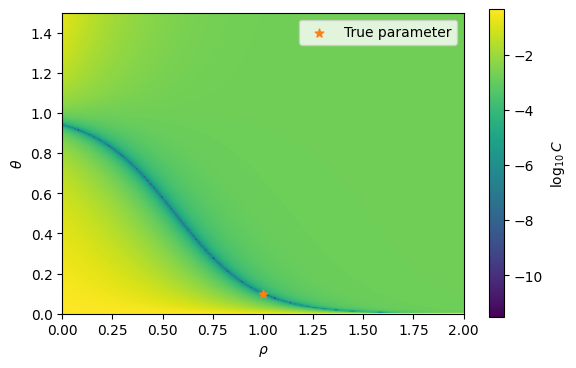

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numpy as np
torch.set_default_dtype(torch.float64)
from scipy.optimize import golden

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 観測時刻
T = 5.0
T = torch.tensor(T)

# 厳密解
def exact_solution(t,_theta,_rho):
  return K / ( 1 + (K/_theta-1)*torch.exp(-_rho*t) )

# 観測時刻での個体数 y
y = exact_solution(T,theta,r).item()

# 色々な theta, rho でのコスト関数を計算
theta_min, theta_max = 0, 1.5
rho_min, rho_max = 0, 2
_theta_list = torch.linspace(theta_min, theta_max,256)
_rho_list = torch.linspace(rho_min, rho_max,256)
_theta, _rho = torch.meshgrid(_theta_list,_rho_list,indexing="ij")
C = 0.5 * torch.square( y - exact_solution(T,_theta,_rho) )

C = torch.log10(C)

# 描画
figheight = 4
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))
im = ax.imshow(C,origin='lower',extent=(rho_min, rho_max, theta_min, theta_max))
cbar = plt.colorbar(im)
cbar.set_label(r"$\log_{10} C$")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\theta$")
ax.set_xlim(rho_min,rho_max)
ax.set_ylim(theta_min,theta_max)

ax.scatter([r],[theta],label="True parameter",marker="*",s=40,color="C1")
plt.legend()
plt.show()
plt.close()



コスト関数が小さくなるパラメータ $(\theta,\rho)$ の組が、ある曲線の上に分布しているように見える。
<br>
<br>
この曲線上のパラメータは全てコスト関数の最小値を与えており、大域的最小解は一意に定まらない。
<br>
実際、$\rho$ を固定した時の最小値を実現する $\theta$ の値とその時のコスト関数値を正確に計算してみると、

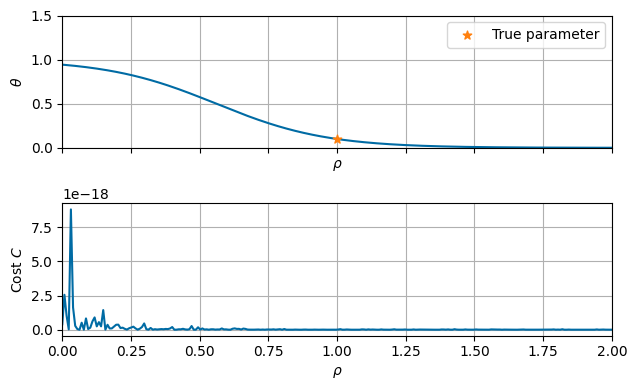

In [ ]:
# 注：　このセルは直前のセルの変数を共有しています。

# rho を固定した時の最小値を与える theta とそのコスト関数値を計算
sol = []
for rho in _rho_list:
  res = golden( lambda x : 0.5 * torch.square( y - exact_solution(T,torch.tensor(x),rho) ).item(), brack=(theta_min, theta_max),full_output=True)
  sol.append([res[0],res[1]])
sol = np.array(sol).T

figheight = 4
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(figheight*1.618, figheight),sharex=True)
ax[0].plot(_rho_list.detach().numpy().copy(), sol[0])
ax[0].set_xlabel(r"$\rho$")
ax[0].set_ylabel(r"$\theta$")
ax[0].set_xlim(rho_min,rho_max)
ax[0].set_ylim(theta_min,theta_max)
ax[0].scatter([r],[theta],label="True parameter",marker="*",s=40,color="C1",zorder=1000)
ax[0].legend()
ax[0].grid("--")

ax[1].plot(_rho_list.detach().numpy().copy(), sol[1])
ax[1].set_xlabel(r"$\rho$")
ax[1].set_ylabel(r"Cost $C$")
ax[1].grid("--")

plt.tight_layout()
plt.show()
plt.close()

$\rho$ を固定して $\theta$ だけを変数とみたときのコスト関数の最小値は全て倍精度実数の範囲でほぼゼロとなっている。<br>つまり、上図の曲線上の $(\theta,\rho)$ 全てが、大域的最小解であると言える。

【考察】
1.   なぜ大域的最小解が一意に決まらないのかを、ロジスティック方程式の解の形から考察せよ。

<br>
<br>

##2.2 問題設定（修正）

上記のようなコスト関数に対し、アジョイント法による最適化を行なっても、残念ながら最小値が一意でないために真の解を見つけることはできない。
<br>
最小解が一意に定まらない場合の対応策の1つとして、新たな情報を追加することが挙げられる。すなわち、1つの観測だけでなく、他の時刻での情報も付け加えることを考える。コスト関数を以下のように修正する。
<br>
<br>

時刻 $t=T_{1}$ の時に個体数 $y_{1}$、時刻 $t=T_{2}$ の時に個体数 $y_{2}$ が観測できたとして $(T_{1}\neq T_{2})$、コスト関数を

\begin{equation}
C = \frac{1}{2}(y_{1}-x_{T_{1}})^{2} + \frac{1}{2}(y_{2}-x_{T_{2}})^{2}
\end{equation}
と定義する。

<br>

同様に、コスト関数の値を$\theta$, $\rho$を変えて見てみよう。

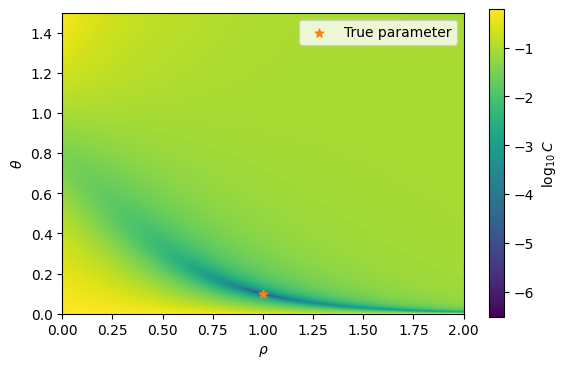

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numpy as np
torch.set_default_dtype(torch.float64)
from scipy.optimize import golden

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1

# 観測時刻
T = 5.0
T = torch.tensor(T)
T1 = 0.5*T
T2 = T



# 厳密解
def exact_solution(t,_theta,_rho):
  return K / ( 1 + (K/_theta-1)*torch.exp(-_rho*t) )

# 観測時刻での個体数 y
y1 = exact_solution(T1,theta,r).item()
y2 = exact_solution(T2,theta,r).item()

# 色々な theta, rho でのコスト関数を計算
theta_min, theta_max = 0, 1.5
rho_min, rho_max = 0, 2
_theta_list = torch.linspace(theta_min, theta_max,512)
_rho_list = torch.linspace(rho_min, rho_max,512)
_theta, _rho = torch.meshgrid(_theta_list,_rho_list,indexing="ij")
C = 0.5 * torch.square( y1 - exact_solution(T1,_theta,_rho) ) + 0.5 * torch.square( y2 - exact_solution(T2,_theta,_rho) )

C = torch.log10(C)

# 描画
figheight = 4
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))
im = ax.imshow(C,origin='lower',extent=(rho_min, rho_max, theta_min, theta_max))
cbar = plt.colorbar(im)
cbar.set_label(r"$\log_{10} C$")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\theta$")
ax.set_xlim(rho_min,rho_max)
ax.set_ylim(theta_min,theta_max)

ax.scatter([r],[theta],label="True parameter",marker="*",s=40,color="C1")
plt.legend()
plt.show()
plt.close()


観測が1つだけの時と比べて、真の解以外のところがぼやけ、最適解が一意に定まっているように見える。実際、上と同じように $\rho$ を固定して、最小値を実現する $\theta$ の値とその時のコスト関数値を正確に計算してみると、

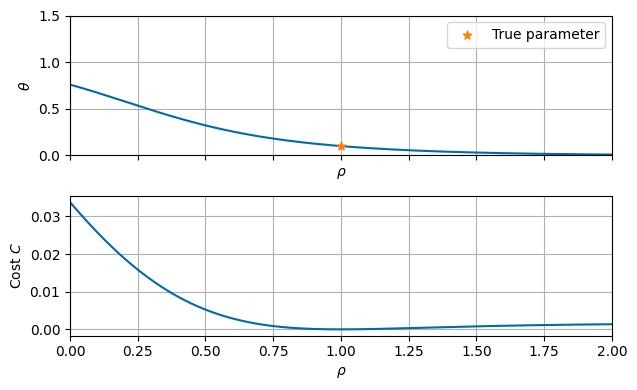

In [ ]:
# 注：　このセルは直前のセルの変数を共有しています。

# rho を固定した時の最小値を与える theta とそのコスト関数値を計算
sol = []
for rho in _rho_list:
  res = golden( lambda x : 0.5 * torch.square( y1 - exact_solution(T1,torch.tensor(x),rho) ).item()+0.5 * torch.square( y2 - exact_solution(T2,torch.tensor(x),rho) ).item(), brack=(theta_min, theta_max),full_output=True)
  sol.append([res[0],res[1]])
sol = np.array(sol).T

figheight = 4
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(figheight*1.618, figheight),sharex=True)
ax[0].plot(_rho_list.detach().numpy().copy(), sol[0])
ax[0].set_xlabel(r"$\rho$")
ax[0].set_ylabel(r"$\theta$")
ax[0].set_xlim(rho_min,rho_max)
ax[0].set_ylim(theta_min,theta_max)
ax[0].scatter([r],[theta],label="True parameter",marker="*",s=40,color="C1",zorder=1000)
ax[0].legend()
ax[0].grid("--")

ax[1].plot(_rho_list.detach().numpy().copy(), sol[1])
ax[1].set_xlabel(r"$\rho$")
ax[1].set_ylabel(r"Cost $C$")
ax[1].grid("--")
plt.tight_layout()
plt.show()
plt.close()

真の解付近でコスト関数は最小となり、大域的最小解が一意に決まっているのが確認できる。<br>このようなコスト関数であれば、アジョイント法による最適化で真の解に到達できることが期待できる。

【考察】
1.   観測を2つにしたことで大域的最小解が一意に定まった理由を、ロジスティック方程式の解の形から考察せよ。

<br>
<br>

##2.3 アジョイント方程式の導出

修正した問題設定のもと、ロジスティック方程式のアジョイント方程式を導出する。

再喝であるが、$z_{t}=(x_{t},r_{t})^{\top}$を変数とするロジスティック方程式は以下のように与えられる。

\begin{equation}
\frac{dz_{t}}{dt} = f(z_{t}) =
\left(
\begin{array}{c}
r_{t}x_{t}\left( 1-\frac{x_{t}}{K} \right) \\
0
\end{array}
\right)
\end{equation}

$x_{t}$, $r_{t}$ に対応するアジョイント変数をそれぞれ $\lambda_{t}$, $\mu_{t}$ として、$\psi_{t}=(\lambda_{t},\mu_{t})^{\top}$ とベクトル表記する。
<br>

アジョイント方程式を記述する際、観測時刻が $t=T_{1},T_{2} < T'$ のように複数の場合には

\begin{equation}
\begin{aligned}
-\frac{d\psi_{t}}{dt} &= \left(\nabla_{z_{t}}f(z_{t})\right)^{\top} \psi_{t} + \sum_{\tau=T_{1},T_{2}} \frac{\partial C}{\partial z_{\tau}}\delta\left(t-\tau\right)\\
\psi_{T'} &= 0
\end{aligned}
\end{equation}


と表現するのが便利である。$T'$ は観測時刻 $(T_{1},T_{2})$ よりも適当に大きい時刻、$\delta(x)$ はディラックのデルタ関数である。
この公式はコスト関数による寄与をデルタ関数による"撃力"として方程式に埋め込んだ表式となっている。
<br>

この公式に $f(z_{t})$ とコスト関数を代入すると、$\psi_{t}=(\lambda_{t},\mu_{t})^{\top}$ が従うアジョイント方程式は以下のように与えられる。

\begin{equation}
\begin{aligned}
-\frac{d\lambda_{t}}{dt} &= r_{t}\left( 1-\frac{2x_{t}}{K_{t}} \right)\lambda_{t} +  \left( x_{T_{1}} - y_{1}\right) \delta(t-t_{1})+ \left( x_{T_{2}} - y_{2}\right) \delta(t-t_{2}) \\
\lambda_{T'} &= 0\\
\\
-\frac{d\mu_{t}}{dt} &= x_{t}\left( 1-\frac{x_{t}}{K} \right)\lambda_{t}\\
\mu_{T'} &= 0
\end{aligned}
\end{equation}

【演習】
1.   上記のロジスティック方程式のアジョイント方程式を導出せよ。

<br>
<br>


##2.4 離散化



上記のデモと同様に、ロジスティック方程式を陽的オイラー法で離散化する。
<br>

時間を $t=nh$ と離散化すると、ロジスティック方程式は以下のように書くことができる。

\begin{equation}
\begin{aligned}
x_{n+1} &= x_{n}+ h r_{n} x_{n}\left( 1- \frac{x_{n}}{K}\right)\\
r_{n+1} &= r_{n}
\end{aligned}
\end{equation}

<br>
<br>

アジョイント方程式は、上記の「少し"不思議"な方法①」で離散化することにする。（つまり、アジョイント方程式の右辺に含まれる $z_{t}$ を $t=t_{n}$、$\psi_{t}$ を $t=t_{n+1}$ で評価する。）

観測時刻 $(T_{1},T_{2})$ でのステップ番号$n$をそれぞれ $(n_{1},n_{2})$ とすると、離散化されたアジョイント方程式は、
\begin{equation}
\begin{aligned}
\lambda_{n}&=\left\{1 + hr_{n}\left( 1- \frac{2x_{n}}{K}\right)\right\}\lambda_{n+1} +  \left(x_{n_{1}} -y_{1}\right) \delta_{n,n_{1}}+ \left(x_{n_{2}} -y_{2}\right) \delta_{n,n_{2}}\\
\mu_{n}&=\mu_{n+1} + hx_{n}\left( 1- \frac{x_{n}}{K}\right)\lambda_{n+1}
\end{aligned}
\end{equation}

と書くことができる。ここで、$\delta_{ij}$ はクロネッカーのデルタを表す。


<br>
<br>

【発展】
1.   【2.3 アジョイント方程式の導出】にある常微分方程式のアジョイント方程式から上記の離散化されたアジョイント方程式を導出せよ。（ヒント：単純に時間微分を差分に置き換えるだけだとデルタ関数のところで数学的な曖昧さが残り気持ち悪さを感じる方がいるかもしれない。別の導出法として、常微分方程式の両辺を時間区間 $[t_{n},t_{n+1}]$ で積分してみよ。）

<br>
<br>


##2.5 アジョイント法を用いた最適化

（大変だったがやっと）アジョイント方程式の離散化表現を構築できたので、実際にロジスティック方程式とそのアジョイント方程式の数値計算を行い、アジョイント法による最適化を実行してみよう。

 Observation :  index   500 time 2.500e+00 value 5.751209e-01
 Observation :  index  1000 time 5.000e+00 value 9.428256e-01

 epoch:     0  value: 1.00000e+00 5.00000e-01 grad: 1.25902e-01 0.00000e+00  exact cost: 9.18956e-02 numerical cost: 9.18956e-02
 epoch:   100  value: 4.18462e-01 4.07207e-01 grad: 3.14708e-02 -1.20915e-02  exact cost: 8.74997e-03 numerical cost: 8.74381e-03
 epoch:   200  value: 1.93986e-01 7.24316e-01 grad: 6.46309e-03 -7.07486e-03  exact cost: 1.12317e-03 numerical cost: 1.11550e-03
 epoch:   300  value: 1.31116e-01 8.86483e-01 grad: 1.41693e-03 -2.25930e-03  exact cost: 1.40249e-04 numerical cost: 1.36865e-04
 epoch:   400  value: 1.12212e-01 9.52060e-01 grad: 4.38308e-04 -8.10710e-04  exact cost: 2.21212e-05 numerical cost: 2.06519e-05
 epoch:   500  value: 1.05039e-01 9.80025e-01 grad: 1.53046e-04 -3.01316e-04  exact cost: 3.77436e-06 numerical cost: 3.08838e-06
 epoch:   600  value: 1.02180e-01 9.91727e-01 grad: 5.30520e-05 -1.07177e-04  exact cost: 7.7217

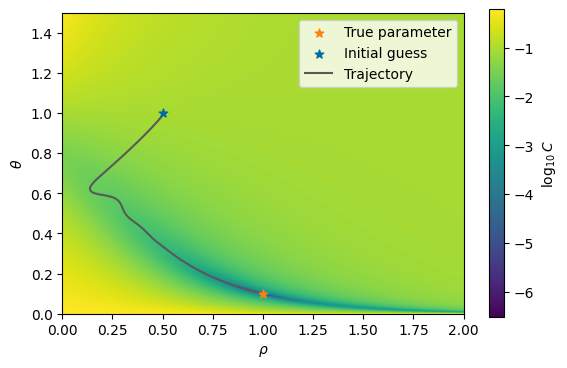

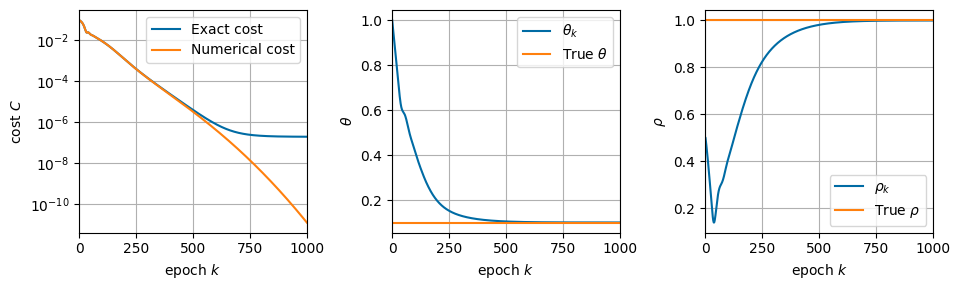

In [ ]:
import torch, time
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
torch.set_default_dtype(torch.float64)
import numpy as np

# パラメータの設定
r = 1.0
K = 1.0
theta = 0.1


# 厳密解
def exact_solution(t,_theta,_rho):
  return K / ( 1 + (K/_theta-1)*torch.exp(-_rho*t) )

# 観測時刻
T = 5.0
T1 = 0.5*T
T2 = T
observation_time = torch.tensor([T1,T2])


# 観測時刻での個体数 y
observations = []
for tt in observation_time:
  observations.append( exact_solution(tt,theta,r).item() )
observations = torch.tensor(observations)


# ステップ数とシミュレーション時間長
num = 1000 # シミュレーションの時刻が観測時刻を踏むようするために、h が T1,T2を正確に割り切るように設定した方が良い。
Tmax = T
h = Tmax/num # タイムステップ
t = torch.linspace(0,Tmax+h,num+2)
indx_observation = torch.tensor([ torch.min(torch.where(torch.abs(t-tobs)<1e-8)[0]).item() for tobs in observation_time])





for ii,tt,yy, in zip(indx_observation,observation_time,observations):
  print(" Observation :  index {:5d} time {:.3e} value {:3e}".format( ii.item(), tt.item(), yy.item() ))
print("")

# ロジスティック方程式を陽的オイラー法で解く関数
def get_forward_solution(_psi):
  x,r = _psi[0], _psi[1]
  history = [[0,x.item(),r.item(),None]]
  j = 0
  for i,w in enumerate(t[1:]):
    x = x + h * r * x * (1-x/K)
    obs = None
    if torch.where(indx_observation==i+1,True,False).any():
      obs = -(observations[j]-x).item()
      j += 1
    history.append([i+1,x.item(),r.item(),obs])
  return history, x, r


# アジョイント方程式を解く関数
def get_adjoint_solution(z_history):
  lam = torch.tensor(0.0)
  mu = torch.tensor(0.0)
  z_reversed_history = list(reversed(z_history)) [1:]
  for z in z_reversed_history:
    indx, x, r, obs = z[0], z[1], z[2], z[3]
    if obs is not None: lam += obs
    mu += h * x * (1-x/K) * lam
    lam *= (1.0+ h * r * (1.0 - 2.0*x/K) )
  return torch.tensor([lam, mu])


# コスト関数の定義
def exact_cost_function(_theta,_rho):
  C = torch.zeros_like(_theta)
  for tt,yy in zip(observation_time,observations):
    C += 0.5 * torch.square( yy.item() - exact_solution(tt.item(),_theta,_rho) )
  return C
def numerical_cost_function(_theta,_rho):
  psi = torch.tensor([_theta.item(),_rho.item()])
  z_history, final_x, final_r = get_forward_solution(psi)
  C = 0.0
  for z in z_history:
    if z[3] is not None: C += 0.5*z[3]*z[3]
  return C


# 学習率
eta = 0.01

# 初期推定値
thetak = 1.0
rhok = 0.5
initial_guess = [thetak,rhok]



# 最適化法による最適化
psik = torch.tensor(initial_guess)

# =======================
# 最急降下法
#optimizer = torch.optim.SGD([psik],lr=eta)
# Nesterovの加速勾配降下法
#optimizer = torch.optim.SGD([psik],lr=eta,nesterov=True,momentum=0.9)
# Adam法
optimizer = torch.optim.Adam([psik],lr=eta)
# ========================

history = []
start_time = time.time()
for epoch in range(1000):

  z_history, final_x, final_r = get_forward_solution(psik)
  grad = get_adjoint_solution(z_history)

  C_exact = exact_cost_function(psik[0],psik[1]).item()
  C_numer = numerical_cost_function(psik[0],psik[1])
  if epoch % 100 == 0:
    print(" epoch: {:5d}  value: {:.5e} {:.5e} grad: {:.5e} {:.5e}  exact cost: {:.5e} numerical cost: {:.5e}".format(epoch,psik[0].item(),psik[1].item(),grad.data[0].item(),grad.data[1].item(),C_exact, C_numer))
    #if C_numer < 1e-7 : break
  history.append( [epoch,psik[0].item(),psik[1].item(),C_exact,C_numer] )

  optimizer.zero_grad()
  psik.grad = grad.data
  optimizer.step()


history = np.array(history).T

# 最終的に得られた推定値と真値との比較
thetak = psik[0]
rhok = psik[1]
print(" theta true: {:.5e}   estimate: {:.5e} relative error: {:.5e}".format( theta, thetak.item(), np.abs(theta-thetak.item())/np.abs(theta)))
print(" rho true: {:.5e}   estimate: {:.5e} relative error: {:.5e}".format( r, rhok.item(), np.abs(r-rhok.item())/np.abs(r)))
print("")
print(" elapsed time {:.10f} sec".format(time.time()-start_time))
print("")




# 以下で、最適化の軌跡をコスト関数のカラーマップの上に描く。

# 色々な theta, rho でのコスト関数を計算
theta_min, theta_max = 0, 1.5
rho_min, rho_max = 0, 2
_theta_list = torch.linspace(theta_min, theta_max,512)
_rho_list = torch.linspace(rho_min, rho_max,512)
_theta, _rho = torch.meshgrid(_theta_list,_rho_list,indexing="ij")
C = exact_cost_function(_theta,_rho)
C = torch.log10(C)

# 描画
figheight = 4
fig, ax = plt.subplots(figsize=(figheight*1.618, figheight))
im = ax.imshow(C,origin='lower',extent=(rho_min, rho_max, theta_min, theta_max))
cbar = plt.colorbar(im)
cbar.set_label(r"$\log_{10} C$")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\theta$")
ax.set_xlim(rho_min,rho_max)
ax.set_ylim(theta_min,theta_max)
ax.scatter([r],[theta],label="True parameter",marker="*",s=40,color="C1",zorder=1000)
ax.scatter([initial_guess[1]],[initial_guess[0]],label="Initial guess",marker="*",s=40,color="C0",zorder=1000)
ax.plot(history[2],history[1],color="C3",label="Trajectory")
plt.legend()
plt.show()
plt.close()

print("")

figheight = 3
fig, ax = plt.subplots(1,3, figsize=(figheight*2*1.618, figheight))
ax[0].plot(history[0],history[3], label="Exact cost",linestyle="-")
ax[0].plot(history[0],history[4], label="Numerical cost",linestyle="-")
ax[0].grid("--")
ax[0].legend()
ax[0].set_xlabel(r"epoch $k$")
ax[0].set_ylabel(r"cost $C$")
ax[0].set_yscale("log")
ax[0].set_xlim(-1,history[0][-1]+1)
ax[1].plot(history[0],history[1], label=r"$\theta_{k}$",linestyle="-")
ax[1].plot([0,history[0][-1]], [theta,theta], label=r"True $\theta$",linestyle="-")
ax[1].grid("--")
ax[1].legend()
ax[1].set_xlabel(r"epoch $k$")
ax[1].set_ylabel(r"$\theta$")
ax[1].set_xlim(-1,history[0][-1]+1)
ax[2].plot(history[0],history[2], label=r"$\rho_{k}$",linestyle="-")
ax[2].plot([0,history[0][-1]], [r,r], label=r"True $\rho$",linestyle="-")
ax[2].grid("--")
ax[2].legend()
ax[2].set_xlabel(r"epoch $k$")
ax[2].set_ylabel(r"$\rho$")
ax[2].set_xlim(-1,history[0][-1]+1)
plt.tight_layout()
plt.show()
plt.close()



大域的最小解が1つなので、適当な initial guess からスタートしても（ほとんどの場合）真の解へ正しく収束することが確認できるはずである。

>なお、最適化法としてAdam法やNesterovの加速勾配降下法などの慣性のある方法を採用した場合、コスト関数値の列は一般には単調減少列にならず、多少のオーバーシュートをしながら最小解へと収束していく。ニューラルネットの文脈でAdam法などがよく使われるのは、多峰のコスト関数の場合にオーバーシュートにより局所解から抜け出しやすいと信じられているからである。

【演習】
1.   Initial guess、最適化法や学習率を変えて、最適解へ至るまでの軌跡がどのように変化するか観察せよ。

【発展】
1.   観測時刻を3つ4つと増やしていくと収束性・計算時間はどう変化するだろうか。検証してみよ。
2.   方程式に適合しない観測データを挿入するとどうなるか検証してみよ。<br>程度の差はあれ、やり方は色々あるが、例えば、$y_{1},y_{2}$ にノイズを付与してみる、$y_{1},y_{2}$ どちらかをめちゃくちゃな値に改変してみるなど。前者は実データを扱っている状況に近い。

<br>
<br>

【考察】
1.   最初の【1.4 ロジスティック方程式の数値計算】のデモで$r$と時間刻み幅$h$をいろいろ動かしてロジスティック方程式を数値計算してみた方は、$r$と時間刻み幅$h$の取り方によっては、数値解が発散する挙動を観察できた方がいるかもしれない。<br>これは選んだ数値解法（今回は陽的オイラー法）に依存した（物理的ではなく）数値的な不安定性を見ており、与えられた$h$に対して安定的に数値計算できる$r$の範囲が決まってしまうことを意味している。
<br>つまり、時間刻みを先に決めて数値計算した場合、アジョイント法による最適化の際に、不安定化する$r$の値を踏んでしまうことで数値計算が発散し最適化に失敗する場合があることが容易に想定される。<br>このような場合に、どのような対応策があるか考えてみよう。（残念ながら、万能な解決策はないと思われる。）



<br>
<br>